In [1]:
%matplotlib notebook
import h5py
import copy
import numpy as np
import matplotlib.pyplot as plt
from plotutility import estimatorscope, estimatorsilentscope
from pythonwrapper import pwrap

In [3]:
#Earth angular rate in ECEF (rad/s)
earth_rate_ecef= pwrap.lin_Vector3d([0.000000707063506E-4,-0.000001060595259E-4,0.729211585530000E-4])

In [ ]:
class TimeEstimator:
    def __init__(self,maxdelay,cycle_duration):
        pass
    def update(self,sensors):
        pass
    def num_negative_steps

In [4]:
class Estimator1:
    def __init__(self,alpha):
        """ Initialize E"""
        self.alpha= alpha
        self.orbit=pwrap.orb_Orbit()
    def update(self,sensors):
        inorbit= pwrap.orb_Orbit(sensors['t'],pwrap.lin_Vector3d(sensors['r']),pwrap.lin_Vector3d(sensors['v']))
        if inorbit.valid():
            self.orbit= inorbit;

    def norm_pos_error_m(self,sensors,truth):
        #
        trueorbit= pwrap.orb_Orbit(truth['t'],pwrap.lin_Vector3d(truth['r']),pwrap.lin_Vector3d(truth['v']))
        if trueorbit.valid() and self.orbit.valid():
            o= copy.deepcopy(self.orbit)
            o.update(trueorbit.nsgpstime(),earth_rate_ecef)
            return float(np.linalg.norm(np.array(trueorbit.recef())-np.array(o.recef())))
        else:
            return float(np.nan)
    def norm_vel_error_mpers(self,sensors,truth):
        #
        trueorbit= pwrap.orb_Orbit(truth['t'],pwrap.lin_Vector3d(truth['r']),pwrap.lin_Vector3d(truth['v']))
        if trueorbit.valid() and self.orbit.valid():
            o= copy.deepcopy(self.orbit)
            o.update(trueorbit.nsgpstime(),earth_rate_ecef)
            return float(np.linalg.norm(np.array(trueorbit.vecef())-np.array(o.vecef())))
        else:
            return float(np.nan)

In [5]:
!ls test-files 

Gracetest.hdf5           gengracetest.py          utility.py
__pycache__              gps-from-matlab-sim.hdf5


In [6]:
with h5py.File("test-files/gps-from-matlab-sim.hdf5","r") as f:  
    psimtruth= f['truth'][()].astype([('t','i8'),('r','f8',3),('v','f8',3)])
    psimsensors= f['sensors'][()].astype([('t','i8'),('r','f8',3),('v','f8',3)])
with h5py.File("test-files/Gracetest.hdf5","r") as f:  
    gracetruth= f['truth'][()].astype([('t','i8'),('r','f8',3),('v','f8',3)])
    gracesensors= f['sensors'][()].astype([('t','i8'),('r','f8',3),('v','f8',3)])

<IPython.core.display.Javascript object>


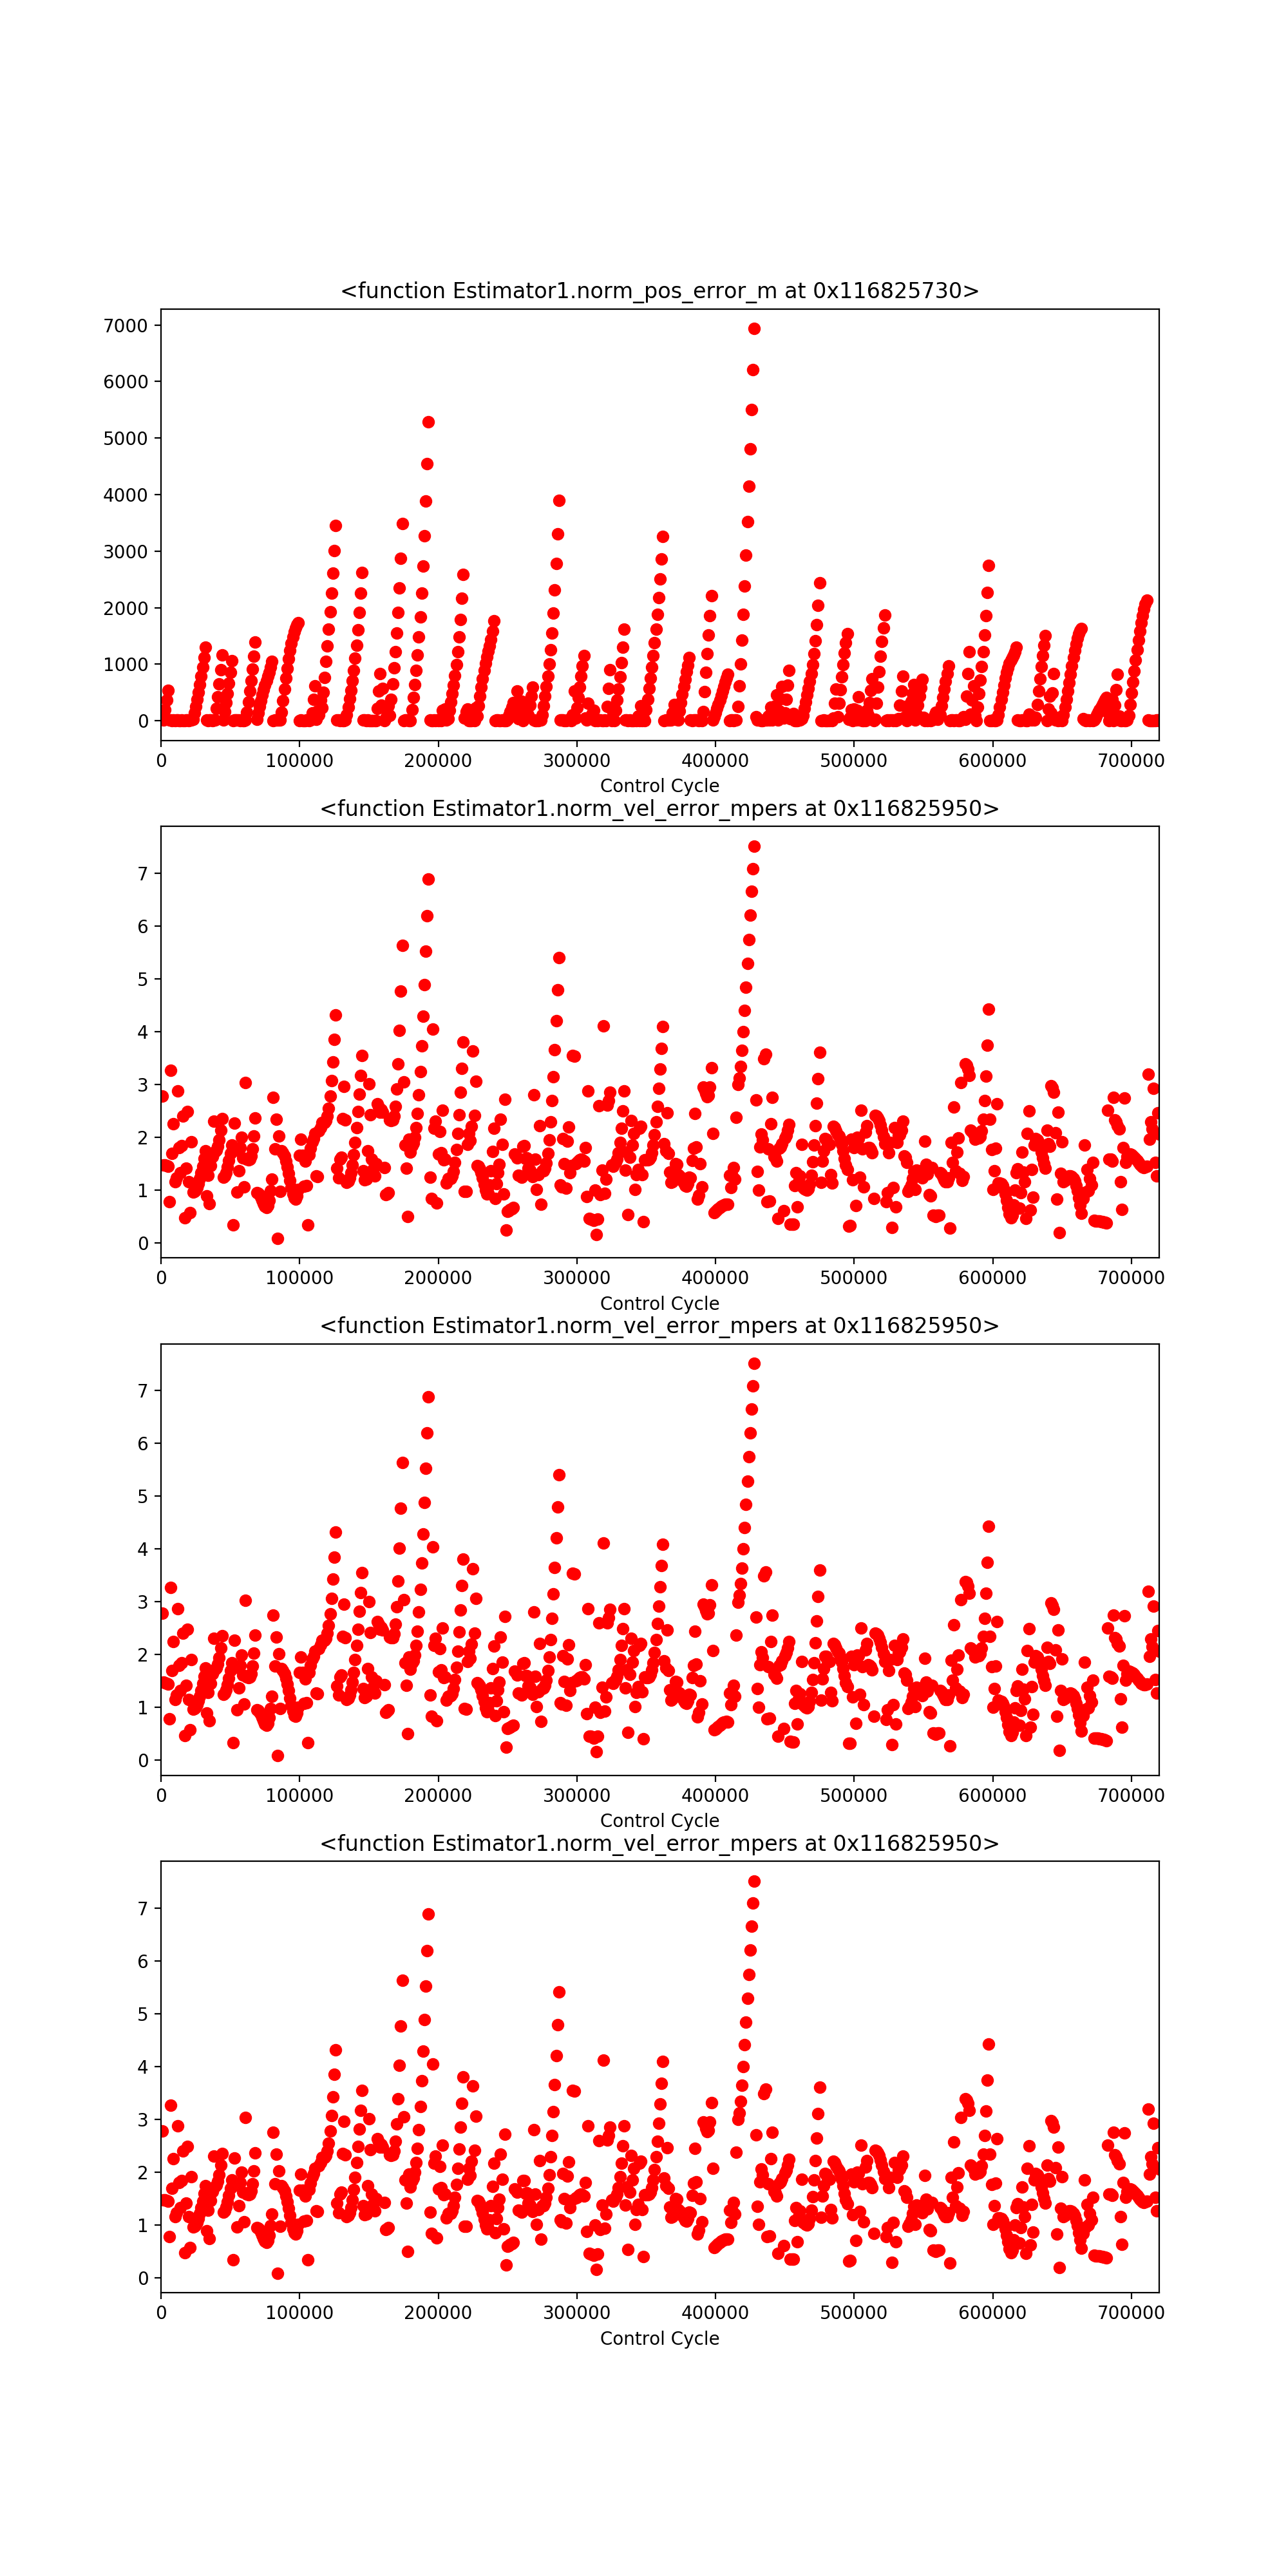

In [7]:
psimb=[]
samplerate=1000
a= estimatorscope(Estimator1(1.0),psimtruth,psimsensors,psimb,samplerate,[Estimator1.norm_pos_error_m,Estimator1.norm_vel_error_mpers,Estimator1.norm_vel_error_mpers,Estimator1.norm_vel_error_mpers])
plt.show(block=True)

<IPython.core.display.Javascript object>


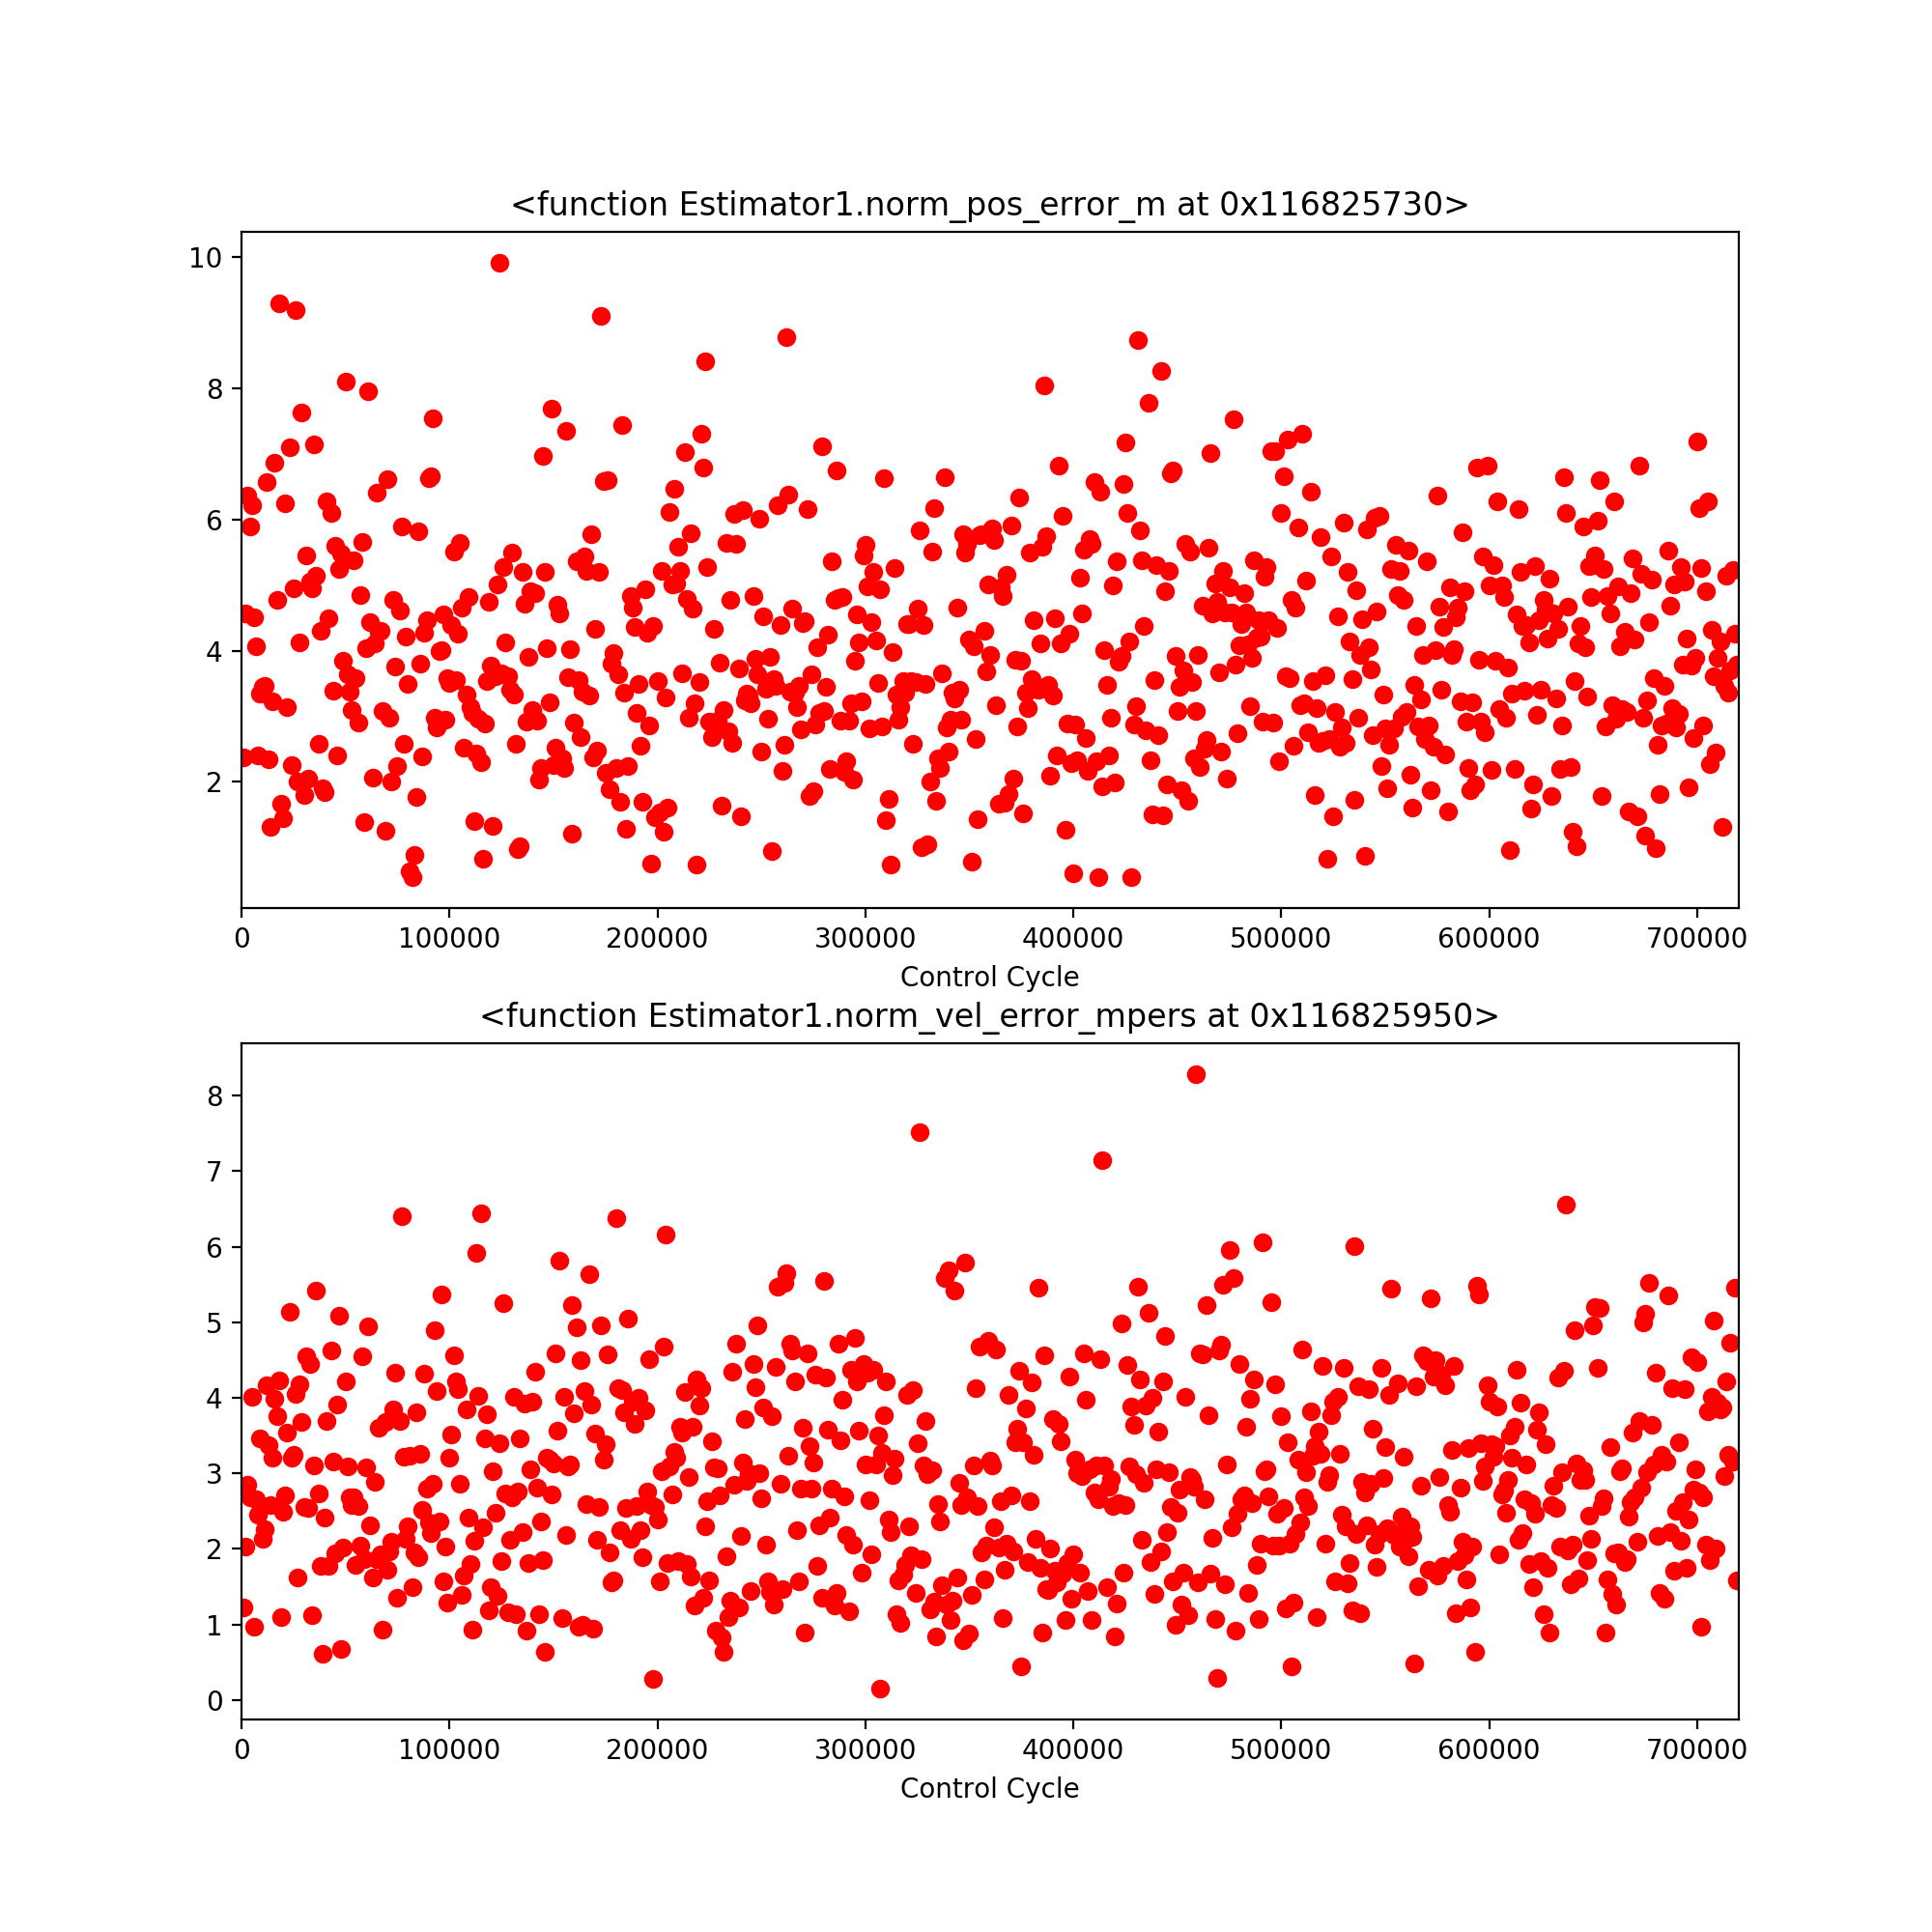

In [8]:
graceb=[]
samplerate=1000
a= estimatorscope(Estimator1(1.0),gracetruth,gracesensors,graceb,samplerate,[Estimator1.norm_pos_error_m,Estimator1.norm_vel_error_mpers])
plt.show(block=True)

In [ ]:
len(graceb)

In [ ]:
type(0)==float